In [20]:
from __future__ import absolute_import, unicode_literals, print_function
import numpy as np
from numpy import pi, cos
import pymultinest as pys
import corner
import numpy as np
import pylab as plt
from scipy.linalg import logm
import corner
import scipy.stats as stat
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
plt.style.use('classic')
import pandas as pd

%matplotlib inline


##  1 .Circularly Gaussian Shaped Function

#### Two Real sources with four model sources

In [21]:
Sources = pd.read_csv('source_list.csv')

## Generated Sources

In [22]:
Sources

,Unnamed: 0,X,Y,R,A
0,0,197.825980,173.184535,4,10.249987
1,1,140.214888,137.263975,4,10.346636
2,2,138.325743,175.367234,4,11.792123
3,3,114.025174,182.872157,4,12.060296
4,4,81.364119,111.436588,4,13.003702
5,5,60.272950,91.694461,4,11.943360
6,6,86.354340,6.994146,4,8.174685
7,7,8.048274,97.969534,4,13.104662
8,8,27.484135,156.631145,4,13.849281
9,9,154.851199,127.284636,4,8.340272


In [23]:
def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
    term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
    return A*np.exp(-term1)

Text(0,0.5,'Y Position')

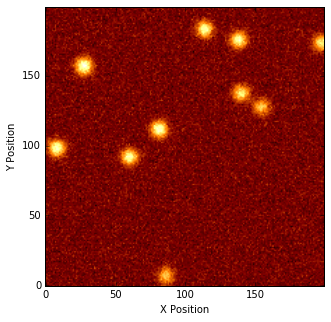

In [24]:
x = np.arange(0, 200, 1, float)
y = x [:,np.newaxis]

source1_template = np.zeros((200,200))
for i in range(len(Sources)):

    X_true = Sources['X'][i]
    Y_true = Sources['Y'][i]
    R_true = Sources['R'][i]
    A_true = Sources['A'][i]

    source1_template += tau(x,y,X_true,Y_true,R_true,A_true) 



# ADD noise of 2 units level

noise = np.random.normal(0,1,source1_template.shape)
Source = source1_template  + noise


plt.figure(figsize=(5,7))
plt.imshow(Source,origin='lower',cmap='afmhot',)
plt.xlabel('X Position')
plt.ylabel('Y Position')
#plt.savefig('Image',bbox_inches='tight')

## 2  Model, Likelihood and prior Equations

In [25]:
def Model(x,y,Xm,Ym,Rm,Am):  #Model that describes each source
    x = np.arange(0, 200, 1, float)
    y = x[:,np.newaxis]
    
    source_template = np.zeros((200,200))
    
    for i in range(len(Xm)):
        
        source_template += tau(x,y,Xm[i],Ym[i],Rm[i],Am[i])
    return source_template


def logLike(cube): #Likelihood function
    cubes = cube.tolist()
    Xm = []
    Ym = []
    Rm = []
    Am = []
    for i in range(15):
        Xm.append(cubes[0])
        Ym.append(cubes[1])
        Rm.append(cubes[2])
        Am.append(cubes[3])
        
        cubes.pop(0)
        cubes.pop(0)
        cubes.pop(0)
        cubes.pop(0)
        
    
    data = Source
    mu = Model(x,y,Xm,Ym,Rm,Am)
    sigma = 1
    term1 = -len(data)*np.log(2*np.pi)/2
    term2 = -(len(data)/2)*np.log(sigma**2)
    term3 = -np.sum((data-mu)**2)/2*(sigma**2)
    
    LogL = term1 + term2 + term3
    
    return LogL 

def mypriors():
    prior_source_list = []
    
    for i in range(15):
        X_prior = 200*np.random.random()
        Y_prior = 200*np.random.random()
        R_prior = 4
        A_prior = 10*np.random.random()+5
        
        prior_source_list.extend([X_prior,Y_prior,R_prior,A_prior]) 
    
    return prior_source_list

def plus(x,y):
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

## 3 Sample N no. of points from the prior

In [39]:
###################Sample N pionts from prior##########################
n = 450  # Number of live points
objects = np.zeros((n,15*4))
l_objects = np.zeros((n))
for i in range(n):
    
    objects[i,:] = mypriors()
    l_objects[i] = logLike(cube = objects[i])


## 4 Initialize Nest

In [40]:
nest = 20000
keep = np.zeros((nest,15*4))
logl_sample = []     #Store Log-likelihood of samples
logX_sample = []        #Store prior mass
   

logWT = []  #Store  weight =width*likelihood


logZ = -np.exp(300)     # SUM(weights)= Z Evidence
H = 0



## 5  Main Nested Sampling Loop

In [41]:
## MAIN NS LOOP##

#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / n))

sigma = 0.7*np.random.random((4))+1.0
for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(l_objects)
    
    #Save worst opbject
    keep[i,:] = objects[worst,:]
    logl_sample.append(l_objects[worst])
    
    #Save prior mass
    logX_sample.append(logw)
    
    #Weight
    logwt = logw + l_objects[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*l_objects[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/n 
   

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(objects))
        if (copy != worst):
            theta = objects[copy,:]
            break
    Likelihood_thresh = l_objects[copy]
    ####################################################################################################################
    increment = 0
    Probability_off = 0.2    #the probability of switching off a model source
    check_num = 0
    
    for num in range(15):   # 4 since the number of models sources is 4 --- iterative over each model source
        
        random_value = np.random.uniform()       #uniform random value
        
    
        if (Probability_off > random_value):  #Switch off the model source
            new_x = np.random.random()      #assign the x position a rnd value
            new_y = np.random.random()      #assign the y position a rnd value
            new_r = 4
            A = 0                              #switch off the amplitude
            
            theta[increment:increment+4] = [new_x,new_y,new_r,A]
            check_num += 1 
        
        increment += 4
    ################ !!! comments !!! #######################################
    '''I decided to iterate over each source and conditionally switch it off or on and then after i went through
    all the sources, i do an mcmc on the samples that are switched-on'''
    #####################################################################################################################

    if (check_num < 15 ):  # If all samples are off , skip otherwise do an mcmc
        while True:
            increment_mc = 0
            for mc_i in range(15):
                
                if theta[increment_mc:increment_mc+4][3] != 0:
                    
                    
                    theta[increment_mc:increment_mc+4] += np.random.normal(0,sigma)
                
                increment_mc += 4
            
            new_point = theta
        
        
            Likelihood_new = logLike(new_point)
        
        
            alpha =  np.exp(-(np.exp(Likelihood_new)-np.exp(Likelihood_thresh))/2)            
        
            if alpha >= 1:
                objects[worst,:] = new_point  #Replace worst point with new point
                l_objects[worst] = Likelihood_new   #Replace the worst likelihood with new one  
                break
            else:
                u = np.random.uniform()
                if u <= alpha :
                    objects[worst,:] = new_point 
                    l_objects[worst] = Likelihood_new
                    break
                else:
                    theta = theta
        else:
            objects[worst,:] = theta
            l_objects[worst] = logLike(theta)
                
    if i >nest*np.exp(H)/np.log(2.):
        break
        

Z = logZ
Z_err = np.sqrt((H)/n)
H = H        #np.exp(H)/np.log(2.)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

Evidence Z = -49078.21280639667 +-0.3316099264924816 : Information H = 49.48431450675707 


## COMMENTS
Changing the Probability_off parameter to ~60%, that is having a higher probability of switching off a model source, 
drops the H term below 10 and to my experience so far this equals to less information from the posterior results.
    
The H term goes over 10 when I start to decrease the Probability_off paramater below ~20% (which is confusing). This case is for 10 real sources and 15 model sources.
  
  
In this case the H term is around 50 and this is usually sufficient to "infer" that the posterior results will have enough information on the paramters in question.

However, the posterior results below in (section 7 "Visualize the Posterior") results look unexpected since I fixed the bug where i was switching on and off. So i think i might be doing something incorrect.

## 6 Weighted Posterior Results

In [29]:
#equally weighted posterior results

prob_weighted = [(logX_sample[i]+logl_sample[i])/Z for i in range(nest)]

prob = prob_weighted/sum(prob_weighted)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(prob*np.log(prob))))

S = 0
sample = np.zeros((effective_sample_size,60))

#Selecting the Effective sample

while True:
    rnd_point = np.random.randint(len(keep))
    proba = prob_weighted[rnd_point]/max(prob_weighted)
    
    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        S += 1
    if S >= effective_sample_size:
        break
print('Effective Sample Size : {}'.format(effective_sample_size))

Effective Sample Size : 19791


## X , Y and A weighted samples

In [33]:
X_sample = []
Y_sample = []
A_sample = []

## Save samples to csv file

In [98]:
import pandas as pd

df =  pd.DataFrame({'X':X_sample,'Y':Y_sample,'A':A_sample})

In [21]:
df.to_csv('SampleS.txt',sep='\t')

## 7 Visualize the Posterior results

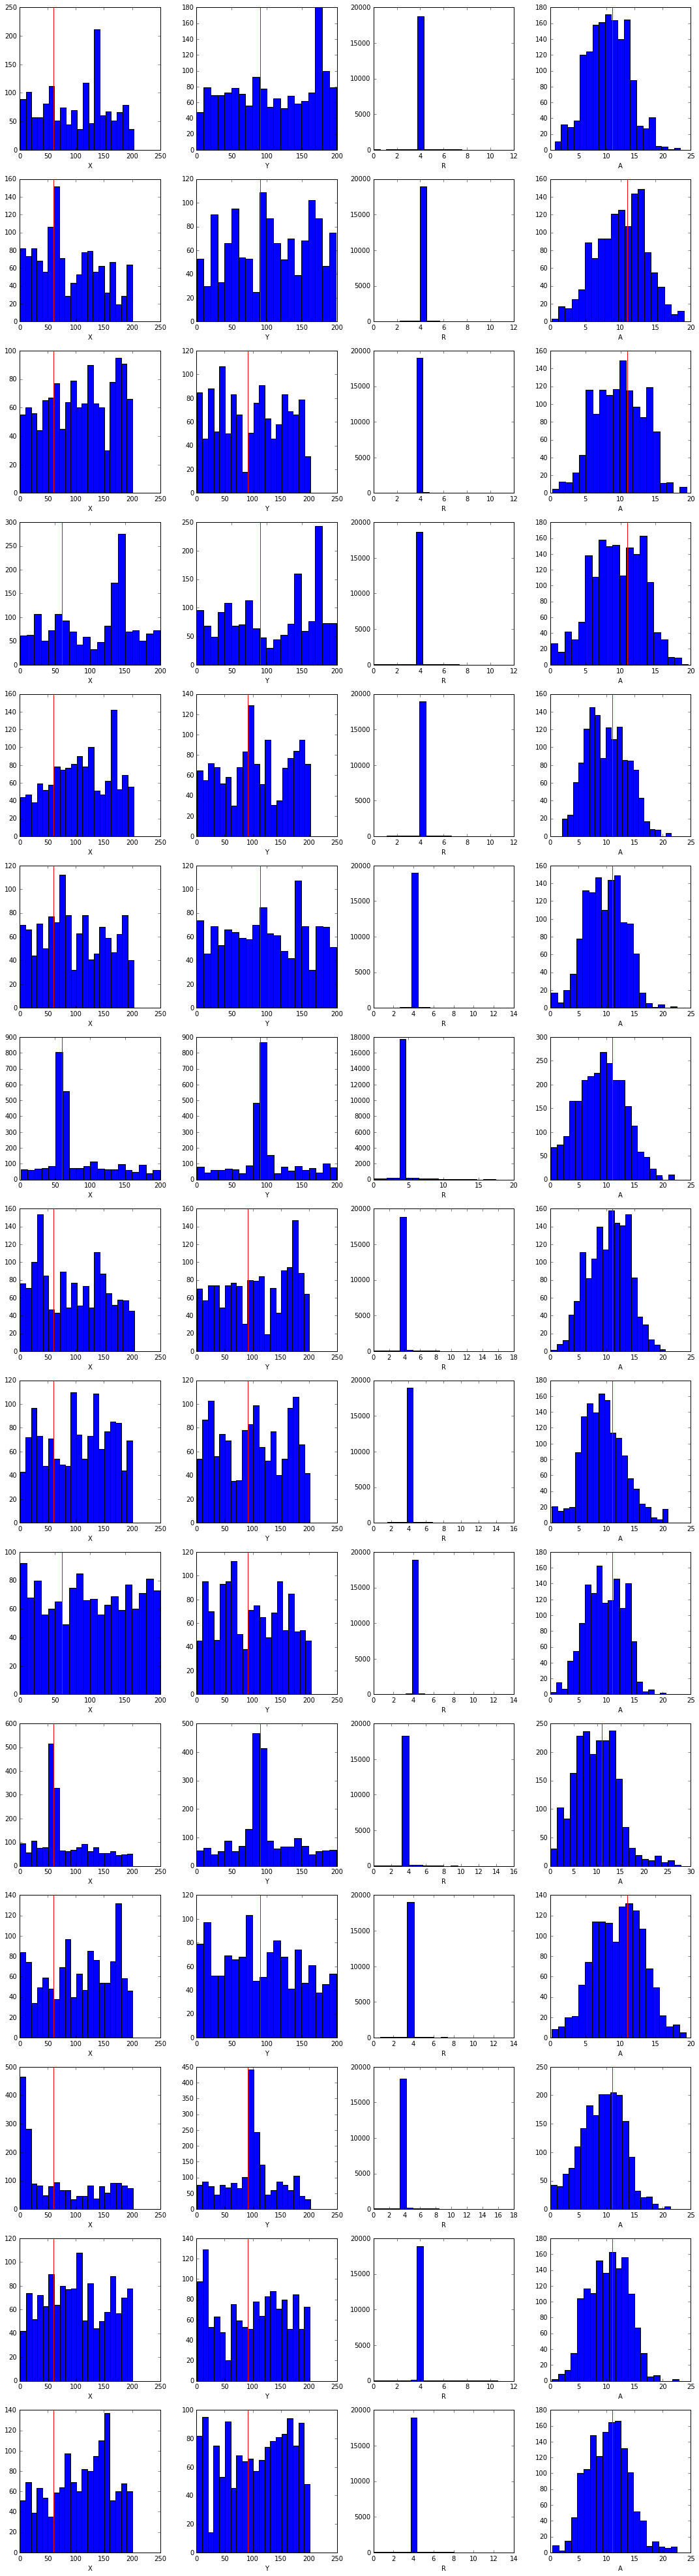

In [49]:
plt.figure(figsize=(15,55))

for i in range(60):
    plt.subplot(15,4,i+1)
    
    plt.hist(sample[:,i][sample[:,i]>0],bins=20)
    
    if i%4==0:
        plt.xlabel('X')
        plt.axvline(60.2,c='r')
        #plt.axvline(81,c='g')
        #plt.axvline(140.2,c='c')
        X_sample.append(sample[:,i])
        
    elif i%4==1:
        plt.xlabel('Y')
        plt.axvline(91,c='r')
        #plt.axvline(111,c='g')
        #plt.axvline(137.2,c='c')
        Y_sample.append(sample[:,i])
        
    elif i%4==2:
        plt.xlabel('R')
    else:
        plt.xlabel('A')
        plt.axvline(11,c='r')
        #plt.axvline(13,c='g')
        #plt.axvline(10.3,c='c')
        A_sample.append(sample[:,i])
        

    #plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('Problem101',bbox_inches='tight')

In [44]:
X_sample_r = np.concatenate(X_sample)
Y_sample_r = np.concatenate(Y_sample)
A_sample_r = np.concatenate(A_sample)

## 8 X & Y Position plot

Text(0,0.5,'Y')

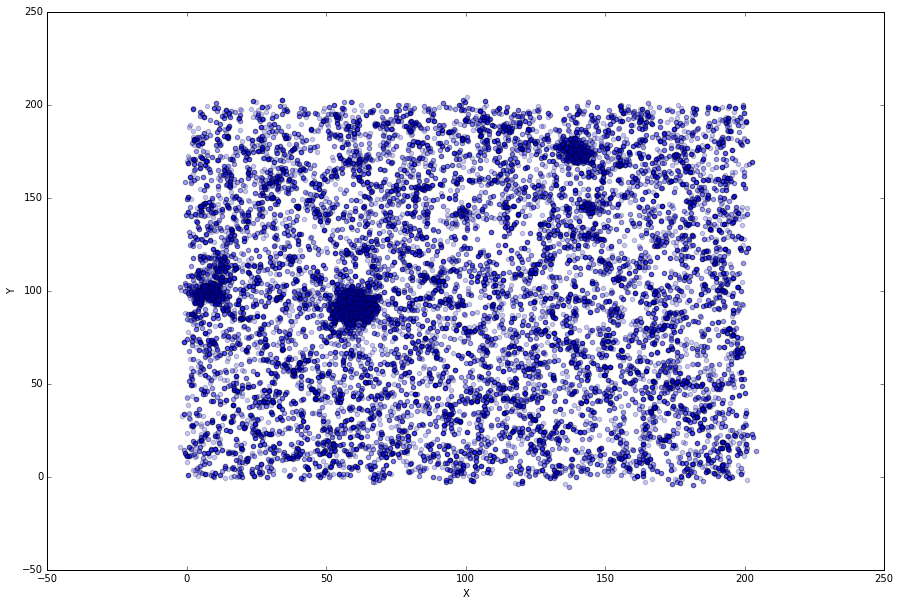

In [50]:
plt.figure(figsize=(15,10))
plt.scatter(X_sample_r[np.where(A_sample_r>0)],Y_sample_r[np.where(A_sample_r>0)],alpha=0.059)
plt.xlabel('X')
plt.ylabel('Y')